# Covid 19 Analysis

In [140]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris, load_digits
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 3) Prediction and Regression
#### 3.1) Random Forest
- - -

In [141]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,...,Confirmed_inc_day_before,Confirmed_inc_day_before_norm,Deaths_inc,Deaths_inc_norm,Deaths_inc_day_before,Deaths_inc_day_before_norm,Recovered_inc,Recovered_inc_norm,Recovered_inc_day_before,Recovered_inc_day_before_norm
0,Afghanistan,33.0000,0.471083,65.0000,0.597360,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
1,Albania,41.1533,0.798304,20.1683,-0.039787,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
2,Alberta (Canada),53.9333,1.311212,-116.5765,-1.983201,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,28.0339,0.271776,1.6596,-0.302833,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
4,Andorra,42.5063,0.852605,1.5218,-0.304791,2020-01-22,0,-1.717183,0,0,...,NaN,NaN,0.0,-0.110666,NaN,NaN,0.0,-0.121130,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30619,Yukon (Canada),64.2823,1.726554,-135.0000,-2.245035,2020-05-16,115,1.717183,11,0,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,NaN,NaN,NaN,NaN
30620,Yunnan (China),24.9740,0.148971,101.4870,1.115912,2020-05-16,115,1.717183,185,2,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373
30621,Zambia,-15.4167,-1.472053,28.2833,0.075543,2020-05-16,115,1.717183,679,7,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,59.0,0.003578,0.0,-0.121373
30622,Zhejiang (China),29.1832,0.317901,120.0934,1.380346,2020-05-16,115,1.717183,1268,1,...,0.0,-0.116999,0.0,-0.110666,0.0,-0.110177,0.0,-0.121130,0.0,-0.121373


In [85]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

#### 3.1.1) Regression for Confirmed Cases
- - -

In [86]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [87]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [6]:
# create Random Forest Regressor instance, and check the hyper parameters
rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

start = time.time()

#search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
search.fit(in_conf_train, out_conf_train)
end = time.time()
elapsed_time = end - start
print('Elapsed time: {}mins'.format(elapsed_time / 60))
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
rf_estimator = search.best_estimator_
rf_estimator


#rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      #max_depth=100, max_features=3, max_leaf_nodes=None,
                      #max_samples=None, min_impurity_decrease=0.0,
                      #min_impurity_split=None, min_samples_leaf=3,
                      #min_samples_split=8, min_weight_fraction_leaf=0.0,
                      #n_estimators=100, n_jobs=None, oob_score=False,
                      #random_state=None, verbose=0, warm_start=False)
#rf_estimator.fit(in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.6min finished


Elapsed time: 5.845779534180959mins
Best score: -19703833.531192064
Best parameters: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 90, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 205.53200101985658
MSE: 2235617.7804334657
RMSE: 1495.1982411819063
R^2: 0.99723228898194


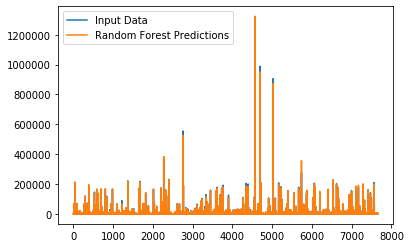

In [34]:
rf_estimator_pred = rf_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(rf_estimator_pred)
plt.legend(['Input Data', 'Random Forest Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, rf_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, rf_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, rf_estimator_pred)))
print('R^2:', r2_score(out_conf_test, rf_estimator_pred))

In [90]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

cv_scores = cross_val_score(rf_estimator_2, inputs, outputs, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

KeyboardInterrupt: 

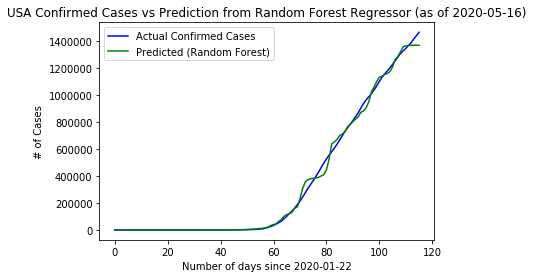

In [36]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = rf_estimator.predict(usa_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

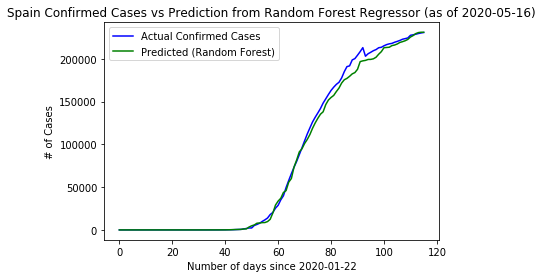

In [37]:
spain_df = df.loc[df["Country/Region"] == "Spain"]
spain_inputs = spain_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
spain_outputs = spain_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
spain_pred_output = rf_estimator.predict(spain_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, spain_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, spain_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Spain Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

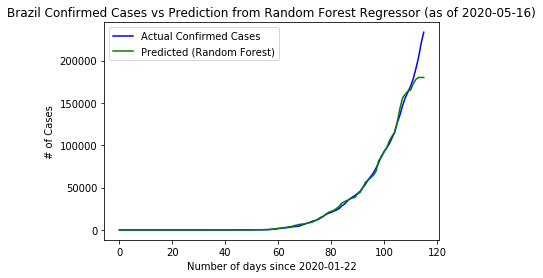

In [38]:
brazil_df = df.loc[df["Country/Region"] == "Brazil"]
brazil_inputs = brazil_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
brazil_outputs = brazil_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
brazil_pred_output = rf_estimator.predict(brazil_inputs)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, brazil_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, brazil_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Brazil Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

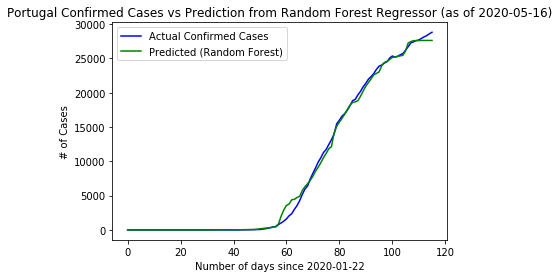

In [39]:
portugal_df = df.loc[df["Country/Region"] == "Portugal"]
portugal_inputs = portugal_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
portugal_outputs = portugal_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
portugal_pred_output = rf_estimator.predict(portugal_inputs)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, portugal_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, portugal_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Portugal Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

NameError: name 'rf_estimator' is not defined

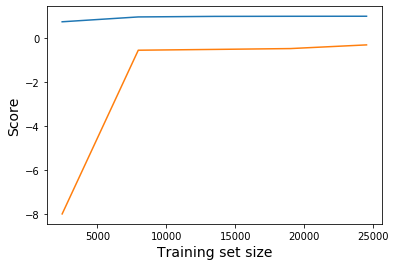

In [89]:
# learning curve (TODO)
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

train_sizes, train_scores, test_scores = learning_curve(estimator=rf_estimator_2, X=inputs, y=outputs, shuffle=True)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Test score')

plt.ylabel('Score', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
title = 'Learning curves for a ' + str(rf_estimator_2).split('(')[0] + ' model'
plt.title(title, fontsize=18, y=1.03)
plt.legend()

# NON NORMALIZED

In [41]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat", "Long", "Num_days_from_begin"]].values
inputs

array([[  33.    ,   65.    ,    0.    ],
       [  41.1533,   20.1683,    0.    ],
       [  53.9333, -116.5765,    0.    ],
       ...,
       [ -15.4167,   28.2833,  115.    ],
       [  29.1832,  120.0934,  115.    ],
       [ -20.    ,   30.    ,  115.    ]])

In [42]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [43]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

start = time.time()

#search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
search.fit(in_conf_train, out_conf_train)
end = time.time()
elapsed_time = end - start
print('Elapsed time: {}mins'.format(elapsed_time / 60))
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
rf_estimator = search.best_estimator_
rf_estimator

#rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      #max_depth=100, max_features=3, max_leaf_nodes=None,
                      #max_samples=None, min_impurity_decrease=0.0,
                      #min_impurity_split=None, min_samples_leaf=3,
                      #min_samples_split=8, min_weight_fraction_leaf=0.0,
                      #n_estimators=100, n_jobs=None, oob_score=False,
                      #random_state=None, verbose=0, warm_start=False)
#rf_estimator.fit(in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  5.2min finished


Elapsed time: 5.55018965403239mins
Best score: -16961458.224204775
Best parameters: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 90, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 246.83397161248993
MSE: 7630748.288524556
RMSE: 2762.380909383164
R^2: 0.9962133949059933


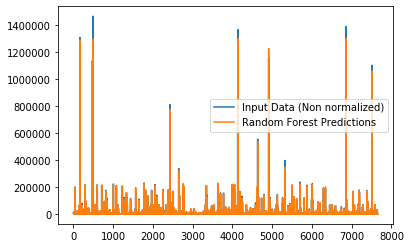

In [44]:
rf_estimator_pred = rf_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(rf_estimator_pred)
plt.legend(['Input Data (Non normalized)', 'Random Forest Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, rf_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, rf_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, rf_estimator_pred)))
print('R^2:', r2_score(out_conf_test, rf_estimator_pred))

Text(0.5, 1.0, 'Average score: -1.0786982517504593')

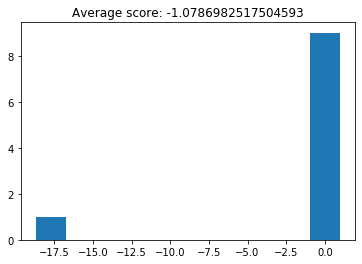

In [45]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

cv_scores = cross_val_score(rf_estimator_2, inputs, outputs, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

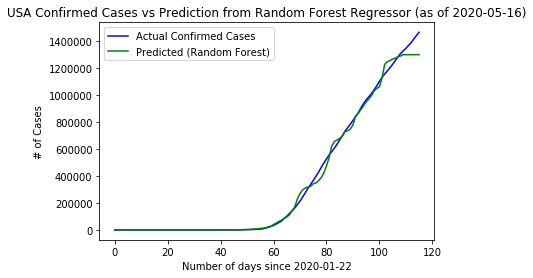

In [48]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat", "Long", "Num_days_from_begin"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = rf_estimator.predict(usa_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

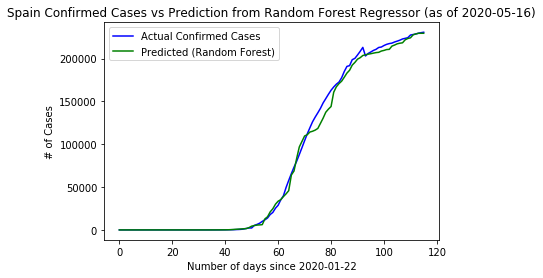

In [50]:
spain_df = df.loc[df["Country/Region"] == "Spain"]
spain_inputs = spain_df[["Lat", "Long", "Num_days_from_begin"]].values
spain_outputs = spain_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()
spain_pred_output = rf_estimator.predict(spain_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, spain_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, spain_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Spain Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

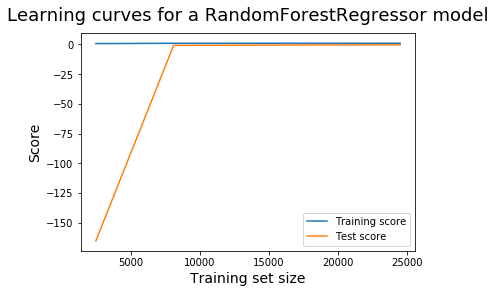

In [51]:
# learning curve
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

train_sizes, train_scores, test_scores = learning_curve(estimator=rf_estimator_2, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True, 
                                       random_state=None, error_score=np.nan, return_times=False)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Test score')

plt.ylabel('Score', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
title = 'Learning curves for a ' + str(rf_estimator_2).split('(')[0] + ' model (Non normalized)'
plt.title(title, fontsize=18, y=1.03)
plt.legend()

# USING INCREMENTS AS OUTPUT

In [5]:
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.71718314],
       [ 0.79830423, -0.03978737, -1.71718314],
       [ 1.3112115 , -1.98320106, -1.71718314],
       ...,
       [-1.47205293,  0.07554281,  1.71718314],
       [ 0.31790115,  1.38034566,  1.71718314],
       [-1.65599721,  0.09994051,  1.71718314]])

In [6]:
# get the output for the machine learning algorithm (confirmed inc cases)
outputs = df["Confirmed_inc"].values
outputs

array([ 0.,  0.,  0., ..., 25.,  0.,  0.])

In [7]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [9]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

start = time.time()

#search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
search.fit(in_conf_train, out_conf_train)
end = time.time()
elapsed_time = end - start
print('Elapsed time: {}mins'.format(elapsed_time / 60))
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
rf_estimator = search.best_estimator_
rf_estimator


#rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      #max_depth=100, max_features=3, max_leaf_nodes=None,
                      #max_samples=None, min_impurity_decrease=0.0,
                      #min_impurity_split=None, min_samples_leaf=3,
                      #min_samples_split=8, min_weight_fraction_leaf=0.0,
                      #n_estimators=100, n_jobs=None, oob_score=False,
                      #random_state=None, verbose=0, warm_start=False)
#rf_estimator.fit(in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


Elapsed time: 1.3914747993151346mins
Best score: -96974.92134688182
Best parameters: {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=110, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 33.836308034057
MSE: 62363.64858640859
RMSE: 249.72714827669137
R^2: 0.9673223121514388


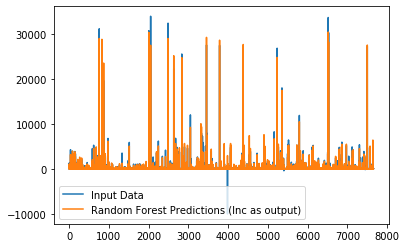

In [10]:
rf_estimator_pred = rf_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(rf_estimator_pred)
plt.legend(['Input Data', 'Random Forest Predictions (Inc as output)'])
print('MAE:', mean_absolute_error(out_conf_test, rf_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, rf_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, rf_estimator_pred)))
print('R^2:', r2_score(out_conf_test, rf_estimator_pred))

Text(0.5, 1.0, 'Average score: 0.4180241179430043')

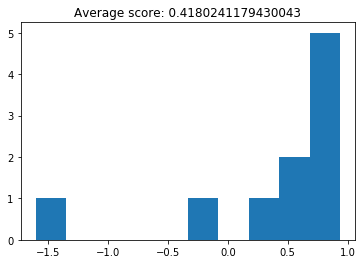

In [11]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

cv_scores = cross_val_score(rf_estimator_2, inputs, outputs, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

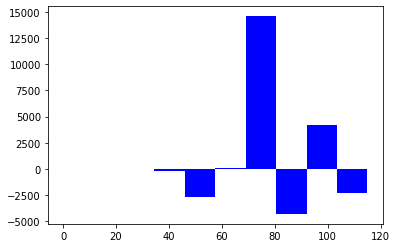

In [23]:
usa_df = df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
usa_outputs = usa_df["Confirmed_inc"].values
days_list = df["Num_days_from_begin"].unique()
usa_pred_output = rf_estimator.predict(usa_inputs)

first_day = df["Date"].min()
last_day = df["Date"].max()

diff_list = np.subtract(usa_outputs, usa_pred_output)

plt.hist(days_list, weights=diff_list, color='blue', label="")
plt.show()

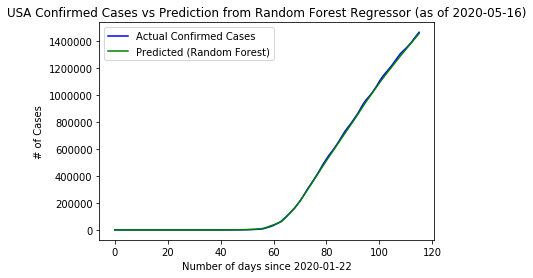

In [24]:
def calc_cumulative(in_list):
    out_list = []
    for idx, elem in enumerate(in_list):
        if idx == 0:
            out_list.append(elem)
        else:
            out_list.append(elem + out_list[idx - 1])
    return out_list

usa_outputs_cumulative = usa_df["Confirmed"].values
usa_pred_cumulative = calc_cumulative(usa_pred_output)

plt.plot(days_list, usa_outputs_cumulative, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_cumulative, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

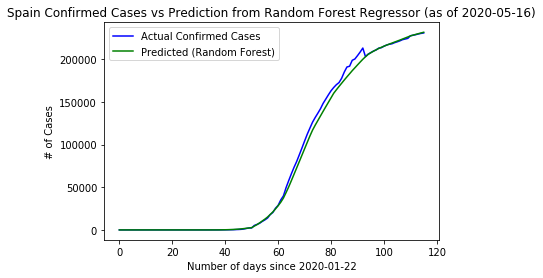

In [25]:
spain_df = df.loc[df["Country/Region"] == "Spain"]
spain_inputs = spain_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
spain_outputs_cumulative = spain_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()

spain_pred_output = rf_estimator.predict(spain_inputs) 
spain_pred_cumulative = calc_cumulative(spain_pred_output)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, spain_outputs_cumulative, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, spain_pred_cumulative, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Spain Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

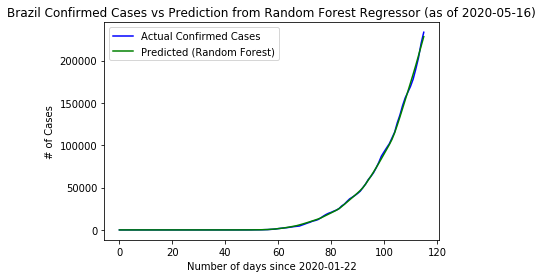

In [26]:
brazil_df = df.loc[df["Country/Region"] == "Brazil"]
brazil_inputs = brazil_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
brazil_outputs_cumulative = brazil_df["Confirmed"].values
days_list = df["Num_days_from_begin"].unique()

brazil_pred_output = rf_estimator.predict(brazil_inputs) 
brazil_pred_cumulative = calc_cumulative(brazil_pred_output)

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, brazil_outputs_cumulative, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, brazil_pred_cumulative, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Brazil Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

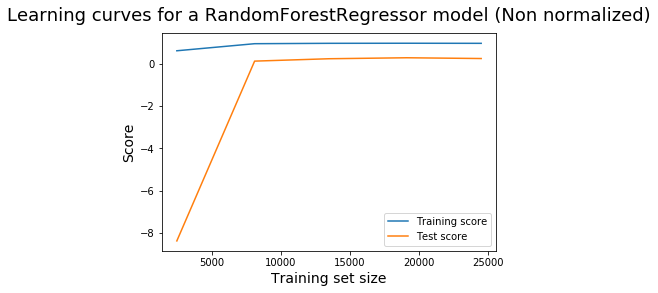

In [27]:
# learning curve (TODO)
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

train_sizes, train_scores, test_scores = learning_curve(estimator=rf_estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True, 
                                       random_state=None, error_score=np.nan, return_times=False)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Test score')

plt.ylabel('Score', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
title = 'Learning curves for a ' + str(rf_estimator_2).split('(')[0] + ' model (Non normalized)'
plt.title(title, fontsize=18, y=1.03)
plt.legend()

# INCREASES AS INPUTS AND CUMULATIVE AS OUTPUT

In [143]:
# get the inputs of the data for the machine learning algorithm
new_df = df.loc[df["Confirmed_inc_day_before_norm"].notna()]

inputs = new_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
inputs

array([[ 0.47108303,  0.59735963, -1.68731909, -0.11699892],
       [ 0.79830423, -0.03978737, -1.68731909, -0.11699892],
       [ 1.3112115 , -1.98320106, -1.68731909, -0.11699892],
       ...,
       [-1.47205293,  0.07554281,  1.71718314, -0.11699892],
       [ 0.31790115,  1.38034566,  1.71718314, -0.11699892],
       [-1.65599721,  0.09994051,  1.71718314, -0.11308895]])

In [145]:
outputs = new_df["Confirmed"].values
outputs

array([   0,    0,    0, ...,  679, 1268,   42])

In [146]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=True)

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

In [147]:
# do hyper parameter tuning with the Random Forest, using cross validation
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

start = time.time()

#search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
search = RandomizedSearchCV(RandomForestRegressor(), param_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=10, verbose=1)
search.fit(in_conf_train, out_conf_train)
end = time.time()
elapsed_time = end - start
print('Elapsed time: {}mins'.format(elapsed_time / 60))
print('Best score: {}'.format(search.best_score_))
print('Best parameters: {}'.format(search.best_params_))
search.best_estimator_
rf_estimator = search.best_estimator_
rf_estimator


#rf_estimator = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      #max_depth=80, max_features=3, max_leaf_nodes=None,
                      #max_samples=None, min_impurity_decrease=0.0,
                      #min_impurity_split=None, min_samples_leaf=3,
                      #min_samples_split=8, min_weight_fraction_leaf=0.0,
                      #n_estimators=200, n_jobs=None, oob_score=False,
                      #random_state=None, verbose=0, warm_start=False)
#rf_estimator.fit(in_conf_train, out_conf_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.6min finished


Elapsed time: 7.650863297780355mins
Best score: -111318110.25138108
Best parameters: {'n_estimators': 1000, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 3, 'max_depth': 110, 'bootstrap': True}


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=110, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

MAE: 728.1405717260625
MSE: 32955278.966754194
RMSE: 5740.668860573147
R^2: 0.9777191695713597


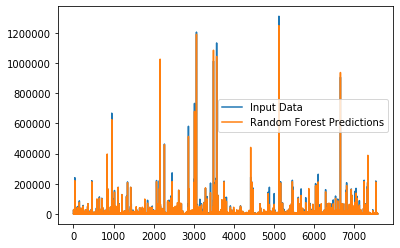

In [148]:
rf_estimator_pred = rf_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(rf_estimator_pred)
plt.legend(['Input Data', 'Random Forest Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, rf_estimator_pred))
print('MSE:',mean_squared_error(out_conf_test, rf_estimator_pred))
print('RMSE:', math.sqrt(mean_squared_error(out_conf_test, rf_estimator_pred)))
print('R^2:', r2_score(out_conf_test, rf_estimator_pred))

Text(0.5, 1.0, 'Average score: -5.520541479574781')

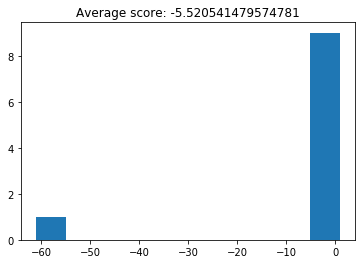

In [149]:
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

cv_scores = cross_val_score(rf_estimator_2, inputs, outputs, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

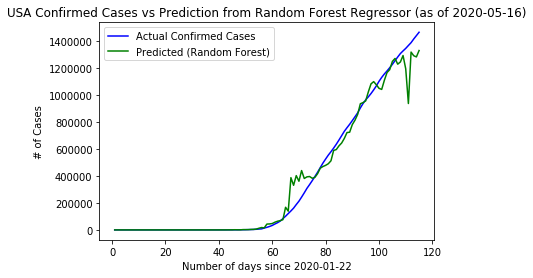

In [152]:
usa_df = new_df.loc[df["Country/Region"] == "US"]
usa_inputs = usa_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
usa_outputs = usa_df["Confirmed"].values
days_list = new_df["Num_days_from_begin"].unique()
usa_pred_output = rf_estimator.predict(usa_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, usa_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, usa_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("USA Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

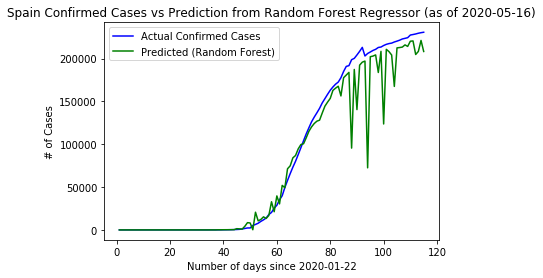

In [173]:
spain_df = new_df.loc[df["Country/Region"] == "Spain"]
spain_inputs = spain_df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm", "Confirmed_inc_day_before_norm"]].values
spain_outputs = spain_df["Confirmed"].values
days_list = new_df["Num_days_from_begin"].unique()
spain_pred_output = rf_estimator.predict(spain_inputs) 

first_day = df["Date"].min()
last_day = df["Date"].max()
plt.plot(days_list, spain_outputs, color='blue', label="Actual Confirmed Cases")
plt.plot(days_list, spain_pred_output, color='green', label="Predicted (Random Forest)")
plt.xlabel("Number of days since {}".format(first_day))
plt.ylabel("# of Cases")
plt.title("Spain Confirmed Cases vs Prediction from Random Forest Regressor (as of {})".format(last_day))
plt.legend()

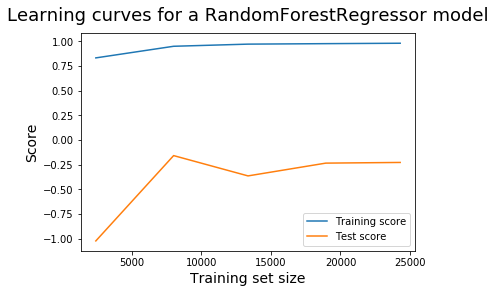

In [174]:
# learning curve (TODO)
rf_estimator_2 = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

train_sizes, train_scores, test_scores = learning_curve(estimator=rf_estimator, X=inputs, y=outputs,
                                       groups=None, 
                                       train_sizes=np.array([0.1, 0.33, 0.55, 0.78, 1. ]),
                                       cv=None, scoring=None, exploit_incremental_learning=False, 
                                       n_jobs=None, pre_dispatch='all', verbose=0, shuffle=True, 
                                       random_state=None, error_score=np.nan, return_times=False)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, test_scores_mean, label='Test score')

plt.ylabel('Score', fontsize=14)
plt.xlabel('Training set size', fontsize=14)
title = 'Learning curves for a ' + str(rf_estimator_2).split('(')[0] + ' model'
plt.title(title, fontsize=18, y=1.03)
plt.legend()

# INCREASES AS INPUTS AND INCREASES AS OUTPUT